In [1]:
import pandas as pd
import numpy as np
from numpy import sin, sign, cos
import pickle
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from src.features import load_trips
from src.models.PhysicalModel import PhysicalModel


rc = {
    "font.sans-serif": ["Fira Sans Condensed", "Arial"],
    "lines.linewidth": 2.5,
    # "axes.grid": True,
    # "axes.grid.axis": "x",
    "grid.linewidth": 1.5,
    "axes.titleweight": "bold",
    "axes.titlelocation": "left",
    "legend.edgecolor": "none",
    "legend.fontsize": "small",
    "legend.title_fontsize": 0,
    "xtick.bottom": True,
    "axes.edgecolor": ".15",
    "figure.figsize": [8.0, 5.0],
    "axes.spines.bottom": True,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme( 
    style="whitegrid",
    context="notebook",
    rc=rc
)

pd.set_option('display.max_columns', None)

In [2]:
df = load_trips(['CPH6_VH'], trips='all', sampling='2s')
df_test = load_trips(['CPH6_HH'], trips='all', sampling='2s')

In [3]:
# df = load_trips(["M3_VH"], trips=[7995], sampling='2s')
# df_test = load_trips(["M3_VH"], trips=[7448], sampling='2s')

In [4]:
# df = df.query("`pass` == 0")
# df_test = df_test.query("`pass` == 0")

In [5]:
# df[["acceleration_y", "acceleration_z", "acceleration_x"]] = df[["acceleration_y", "acceleration_z", "acceleration_x"]] * g
# df_test[["acceleration_y", "acceleration_z", "acceleration_x"]] = df_test[["acceleration_y", "acceleration_z", "acceleration_x"]] * g

In [6]:
# data_dir = "../data/processed"


# def load_trip(routes, trips):
#     dfs = []
#     for route in routes:
#         for trip in trips:
#             df = []
#             for file_path in glob.glob(os.path.join(data_dir, route, f"trip_{trip}_*.pickle")):
#                 with open(file_path, "rb") as f:
#                     df_ = pickle.load(f)
#                 _, trip, i = os.path.splitext(os.path.basename(file_path))[0].split("_")
#                 df_ = df_.assign(trip=trip)\
#                          .assign(route=route)
#             df_ = df_.fillna(np.nan).groupby('segment_id').first().reset_index()
#             df.append(df_)
#         df = pd.concat(df)
#         df = df.fillna(np.nan).groupby('segment_id').first().reset_index()
#         df["obd.trac_cons.value"] = df["obd.trac_cons.value"] - 160
#         dfs.append(df)
#     return pd.concat(dfs)

# df = load_trip(routes=["M3_VH"], trips=[7995])
# df_test = load_trip(routes=["M3_VH"], trips=[7448])

# df[["acc.xyz.x", "acc.xyz.x", "acc.xyz.z"]] = df[["acc.xyz.x", "acc.xyz.y", "acc.xyz.z"]] * g
# df_test[["acc.xyz.x", "acc.xyz.x", "acc.xyz.z"]] = df_test[["acc.xyz.x", "acc.xyz.y", "acc.xyz.z"]] * g

In [7]:
physical_model = PhysicalModel()
physical_model.fit("velocity", "acceleration_y")

TS_or_Distance
2021-08-27 10:00:00+00:00    0.000000
2021-08-27 10:00:02+00:00    0.000000
2021-08-27 10:00:04+00:00    0.000000
2021-08-27 10:00:06+00:00    0.000000
2021-08-27 10:00:08+00:00    0.000000
                               ...   
2021-08-27 10:44:50+00:00    3.250548
2021-08-27 10:44:52+00:00    2.658003
2021-08-27 10:44:54+00:00    2.763204
2021-08-27 10:44:56+00:00    3.634645
2021-08-27 10:44:58+00:00    3.970719
Length: 2384, dtype: float64

In [8]:
df = (
    df.assign(kW_pred=physical_model.predict(df))
      .assign(error=lambda x: (x["kW_pred"] - x["traction_instant_consumption"]))
      .assign(abserror=lambda x: np.abs(x["error"]))
)

df_test = (
    df_test.assign(kW_pred=physical_model.predict(df_test))
    .assign(error=lambda x: (x["kW_pred"] - x["traction_instant_consumption"]))
    .assign(abserror=lambda x: np.abs(x["error"]))
)

C:\Users\s174433\AppData\Local\Temp\ipykernel_11992\412737431.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['street_name_start'], dtype='object')
  sns.lineplot(data=df.rolling("1min").mean().reset_index(), x="TS_or_Distance", y="traction_instant_consumption")
C:\Users\s174433\AppData\Local\Temp\ipykernel_11992\412737431.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['street_name_start'], dtype='object')
  sns.lineplot(data=df.rolling("1min").mean().reset_index(), x="TS_or_Distance", y="kW_pred")


<AxesSubplot:xlabel='TS_or_Distance', ylabel='traction_instant_consumption'>

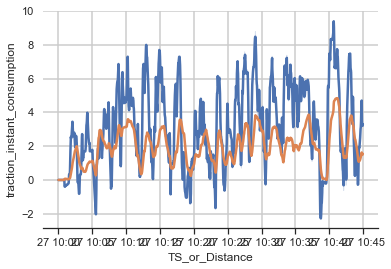

In [9]:
sns.lineplot(data=df.rolling("1min").mean().reset_index(), x="TS_or_Distance", y="traction_instant_consumption")
sns.lineplot(data=df.rolling("1min").mean().reset_index(), x="TS_or_Distance", y="kW_pred")

In [45]:
features = ["acc.xyz.x", "acc.xyz.y", "acc.xyz.z",
            "obd.strg_pos.value", "obd.strg_ang.value", "obd.strg_acc.value",
            "obd.acc_yaw.value", "obd.spd.value", "obd.odo.value",
            "obd.ww_f_stat.value", "obd.sb_rem_fl.value", "traffic_lights",
            "road_signs", "speed_limit", "ped_walks", "speed_bumps", "bike_lane", "start_hour"]

target = "error"

In [29]:
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(df[features], df[target])

LGBMRegressor()

In [30]:
# from sklearn.model_selection import GridSearchCV
# import lightgbm as lgb

# def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
#                        model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
#                        do_probabilities = False):
#     gs = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid, 
#         cv=cv, 
#         n_jobs=-1, 
#         scoring=scoring_fit,
#         verbose=2
#     )
#     fitted_model = gs.fit(X_train_data, y_train_data)

#     if do_probabilities:
#       pred = fitted_model.predict_proba(X_test_data)
#     else:
#       pred = fitted_model.predict(X_test_data)

#     return fitted_model, pred

# model = lgb.LGBMRegressor()
# param_grid = {
#     'n_estimators': [400, 700, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15,20,25],
#     'num_leaves': [50, 100, 200],
#     'reg_alpha': [1.1, 1.2, 1.3],
#     'reg_lambda': [1.1, 1.2, 1.3],
#     'min_split_gain': [0.3, 0.4],
#     'subsample': [0.7, 0.8, 0.9],
#     'subsample_freq': [20]
# }

# model, pred = algorithm_pipeline(df[features].to_numpy(), df_test[features].to_numpy(), df[target].to_numpy(), df_test[target].to_numpy(), model, 
#                                  param_grid, cv=5)

# print(model.best_score_)
# print(model.best_params_)

[Text(0.0, 1.0, 'Compound model prediction on training set')]

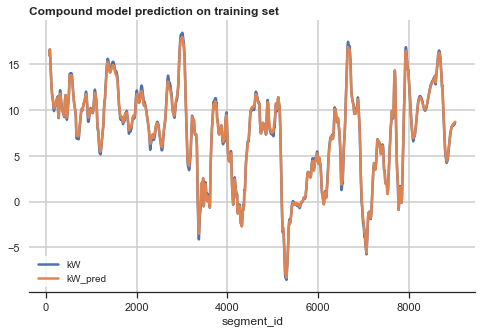

In [31]:
(
df.assign(error_pred=model.predict(df[features]))
  .assign(kW_pred=lambda x: x.kW_pred - x.error_pred)
  .drop(['Date', 'T', 'TS_or_Distance', 'Time', 'route', 'street_name_end', 'street_name_start'], axis=1)
  .rolling(150).mean()
  .plot(x="segment_id", y=["kW", "kW_pred"])
  .set(title="Compound model prediction on training set")
)

-0.35067642154567646


[Text(0.0, 1.0, 'Physical model prediction on test set')]

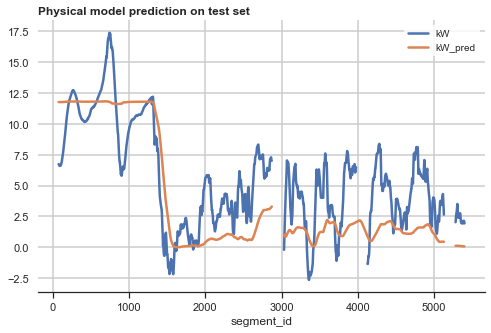

In [32]:
(
df_test
    .assign(kW_pred=lambda x: get_traction_power(x["obd.spd.value"], x["acc.xyz.x"]) / 25000)
    .drop(['Date', 'T', 'TS_or_Distance', 'Time', 'route', 'street_name_end', 'street_name_start'], axis=1)
    .rolling(150).mean()
    .plot(x="segment_id", y=["kW", "kW_pred"])
    .set(title="Physical model prediction on test set")
)

-0.35067642154567646


[Text(0.0, 1.0, 'Compound model prediction on test set')]

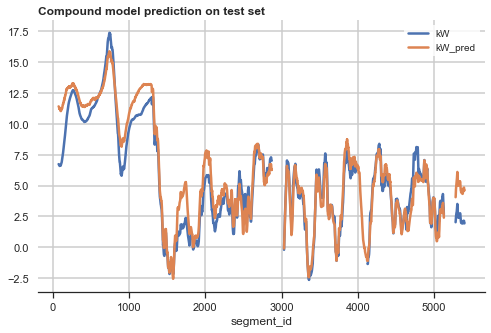

In [33]:
(
df_test.assign(error_pred=model.predict(df_test[features]))
    .assign(kW_pred=lambda x: get_traction_power(x["obd.spd.value"], x["acc.xyz.x"]) / 25000)
    .assign(kW_pred=lambda x: x.kW_pred - x.error_pred)
    .drop(['Date', 'T', 'TS_or_Distance', 'Time', 'route', 'street_name_end', 'street_name_start'], axis=1)
    .rolling(150).mean()
    .plot(x="segment_id", y=["kW", "kW_pred"])
    .set(title="Compound model prediction on test set")
)

Still trying to understand why `acc.xyz.y` has such a huge impact.
However, the impact of `obd.spd.value` is intuitive.
The faster you go, the bigger the effect of road friction, and road friction is one of the two effects (along with the wind) which are not taken into account in the physical model.

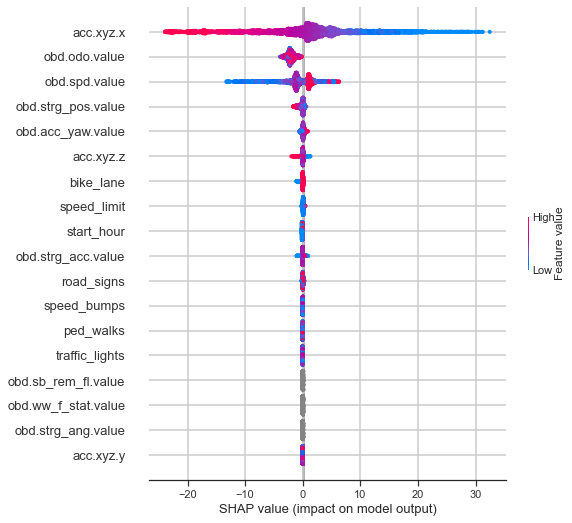

In [34]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test[features])

shap.summary_plot(shap_values, df_test[features])